In [1]:
import json
import sklearn.metrics as skm
from matplotlib import pyplot as plt
import numpy as np

#list_metrics_all = ['mae', 'rmse', 'pearson', 'spearman', 'kendalltau', 'r2_score']
#list_metrics = ['mae', 'rmse', 'pearson', 'r2_score']
list_metrics = ['mae', 'rmse', 'pearson', 'r2_score']
list_predictor = ["mlp",'xgb', 'bananas'] #['mlp', 'xgb', 'gp_path', 'bananas']
#list_seeds = [1000, 2000] 
list_seeds = [1,2,3,4,5]
dataset_name = 'so2sat_lcz42_micro'


In [2]:
dict_per_predictor = dict()

for predictor_i in list_predictor:
    
    dict_per_seed = dict()
    
    for seed_i in list_seeds:

        file_name = '{}/predictors/{}/{}/errors.json'.format(dataset_name, predictor_i, seed_i)

        with open(file_name, 'r') as json_results:
            file_gp_lcz42 = json.loads(json_results.read())   

        config_exps = file_gp_lcz42[0]
        training_size = None

        if config_exps['experiment_type'] == 'vary_train_size':
            training_size = config_exps['train_size_list']
        elif config_exps['experiment_type'] == 'single':
            training_size =  config_exps['train_size_single']
        else:
            pass

        #print('seed:', dict_all_sizes)

        if not file_gp_lcz42[0]['experiment_type'] == 'single':


            number_of_items = len(training_size)

            dict_all_sizes = dict()
            for idx_i, size_i in enumerate(training_size):
                
                r2_score = skm.r2_score(file_gp_lcz42[idx_i + 1]['full_ytest'], 
                                        file_gp_lcz42[idx_i + 1]["full_testpred"])
                
                performance = dict()            
                for metric_k in list_metrics:
                    if metric_k == 'r2_score':
                        performance[metric_k] = performance.get(metric_k, []) + [r2_score]
                    else:
                        value_k = file_gp_lcz42[idx_i + 1][metric_k]
                        performance[metric_k] = performance.get(metric_k, []) + [value_k]

                dict_all_sizes[size_i] = performance
        dict_per_seed[seed_i] = dict_all_sizes
    
    dict_per_predictor[predictor_i] = dict_per_seed

In [3]:
#dict_per_predictor

In [4]:
#dict_per_predictor = dict()

for predictor_i in list_predictor:    
    for seed_i in list_seeds:
        dict_all_sizes = dict()
        for idx_i, size_i in enumerate(training_size):
            for metric_k in list_metrics:
                if dict_per_predictor[predictor_i].get(seed_i - 1, None) is None:
                    previous_value = []
                else:
                    #print(dict_per_predictor[predictor_i][seed_i - 1], metric_k)
                    previous_value = dict_per_predictor[predictor_i][seed_i - 1][size_i][metric_k]
                dict_per_predictor[predictor_i][seed_i][size_i][metric_k] += previous_value

In [5]:
# Retrieve the latest seed value as the final dict
for predictor_i in list_predictor:    
    dict_per_predictor[predictor_i] = dict_per_predictor[predictor_i][list_seeds[-1::][0]]

In [6]:
def box_plot(data, edge_color, fill_color):
    
    flierprops = dict(marker='o', markerfacecolor=edge_color, markersize=2,
                  linestyle='none')
    
    bp = ax.boxplot(data, patch_artist=True, flierprops=flierprops)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

dict_color_metrics = {'mae': 'blue', 'rmse': 'red', 
                      'pearson':'green', 'spearman':'purple', 
                      'kendalltau':'grey', 'r2_score':'black'}

In [7]:
labels_axis = list()
for _ in range(len(list_metrics)):
    labels_axis += training_size

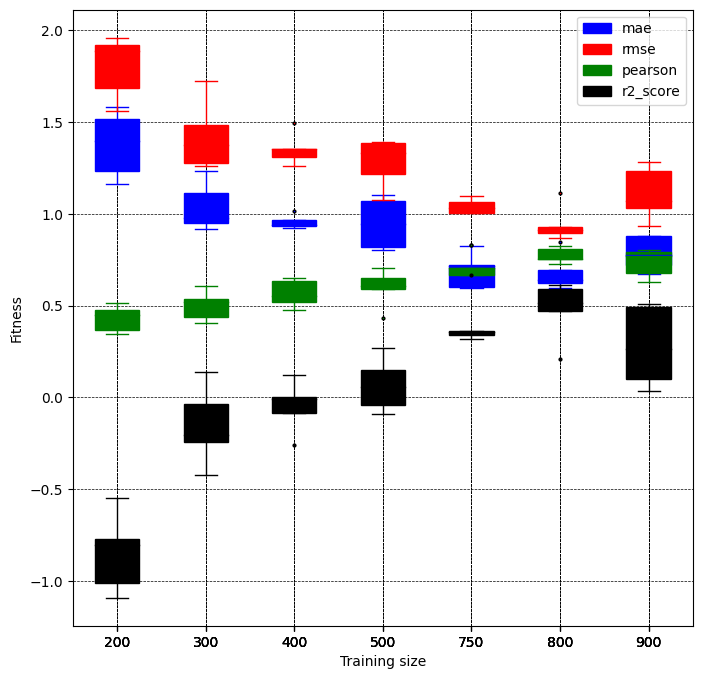

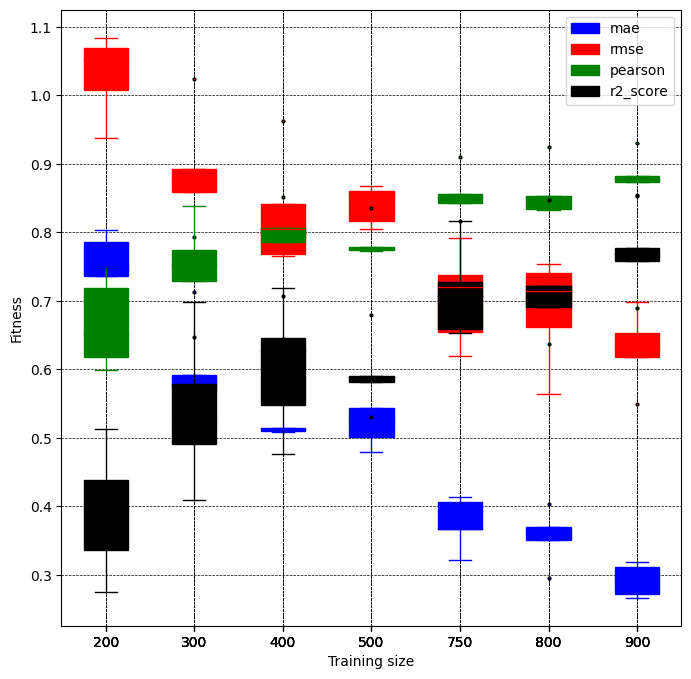

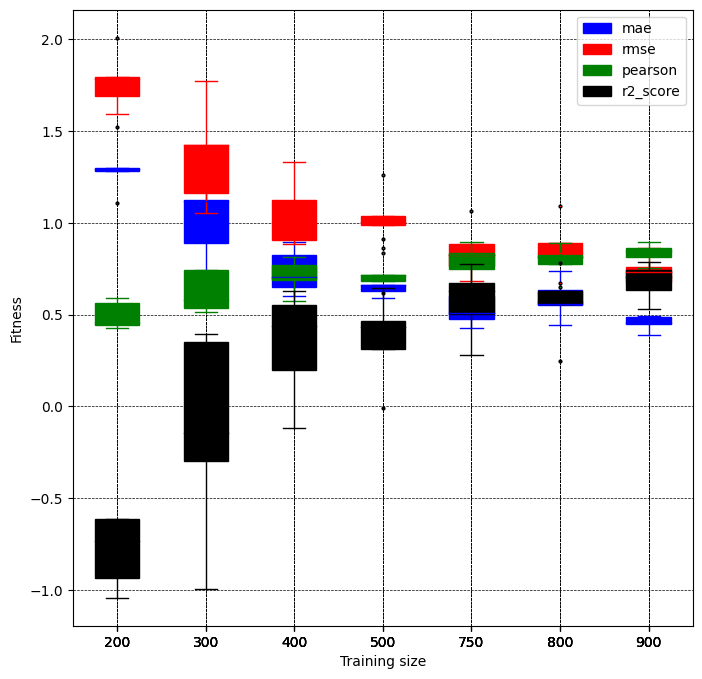

In [8]:
for predictor_i in list_predictor:
    fig, ax = plt.subplots(figsize=(8, 8))
    #fig.set_figwidth(8)
    #plt.title('Fitness of surrogate as function of training size - ' + predictor_i.upper() 
    #      + '\n No learning curve prediction - Test size = 100')    
    #plt.title(dataset_name.upper() + ' - ' + predictor_i.upper() 
    #      + '\n No learning curve prediction - Test size = 100')    
    
    plt.xlabel('Training size')
    plt.ylabel('Fitness')
    list_box_plots = list()
    
    for metric_i in list_metrics:
    
        plt.grid(color = 'black', linestyle = '--', linewidth = 0.5)
        
        data_i = [dict_per_predictor[predictor_i][t_i][metric_i] for t_i in training_size]
        
        bp_i = box_plot(data_i, edge_color=dict_color_metrics[metric_i], 
                        fill_color=dict_color_metrics[metric_i]) 
                        #fill_color='white')
        list_box_plots.append(bp_i)
        
    ax.legend([bp_i["boxes"][0]for bp_i in list_box_plots], [m_k.lower() for m_k in list_metrics])
    ax.set_xticklabels(labels_axis)    
    plt.savefig(dataset_name + '_vary_training_size_' +  predictor_i + '_5_seeds_' + '.png')
    #plt.ylim((-0.1, 1))
    #plt.legend(loc='upper right')